# Time Series Analysis

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Covert the featured label into a discrete column value type, instead of continuous.
* Time Shift the provided datasets with varied 'lag' values.
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set.
* Perform feature selection on the agglomorated matrix, dropping redundant features and finding the  optimum number of features. (Multivariate analysis - through a wrapper approach)
* Feed dataset into a number of machine learning models

Applicable links:
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

### Module Installation and Importing Libraries

https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math

scipy: 0.19.1
numpy: 1.15.2
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.18.1
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


Using TensorFlow backend.


### Read data from file into pandas dataframes

In [2]:
tpcds='TPCDS1' # Schema upon which to operate test
low_quartile_limit = 0 # Lower Quartile threshold to detect outliers
upper_quartile_limit = 1 # Upper Quartile threshold to detect outliers
lag=1 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
test_split=.3 # Denotes which Data Split to operate under when it comes to training / validation
y_label = 'CPU_TIME_DELTA' # Denotes which label to use for time series experiments
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

### Pivoting tables and changing matrix shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [3]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
#
rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)
#
print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))
#
# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 88
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 162
REP_HIST_SYSSTAT: 1179

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (172, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (172, 162)
Table [REP_HIST_SYSSTAT] - (172, 1179)


### Merging frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [4]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df, on='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df, on='SNAP_ID')
print(df.shape)

(172, 1416)


### Dealing with empty values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print('N/A Columns\n')
print('\nFeatures ' + str(len(df.columns)) + ': ' + str(get_na_columns(df=df,headers=df.columns)))
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
df = fill_na(df=df)

N/A Columns


Features 1416: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND TIME PER SEC', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES_x', 'DDL STATEMENTS PARALLELIZED PER SEC', 'DML STATEMENTS PARALLELIZED PER SEC', 'HOST CPU USAGE PER SEC', 'I/O MEGABYTES PER SECOND', 'I/O REQUESTS PER SECOND', 'PX OPERATIONS NOT DOWNGRADED PER SEC', 'QUERIES PARALLELIZED PER SEC', 'REPLAYED USER CALLS', 'RUN QUEUE PER SEC', 'SESSION COUNT', 'TEMP SPACE USED', 'TOTAL PGA ALLOCATED', 'TOTAL PGA USED BY SQL WORKAREAS', 'VM IN BYTES PER SEC', 'VM OUT BYTES PER SEC', 'WORKLOAD CAPTURE AND REPLAY STATUS', 'FORWARDED 2PC COMMANDS ACROSS RAC NODES', 'IM SPACE SMU CREATIONS COMMITTED', 'PARALLEL OPERATIONS DOWNGRADED TO SERIAL']


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [6]:
df.astype('float32', inplace=True)

,SNAP_ID,DBID,INSTANCE_NUMBER,PLAN_HASH_VALUE,OPTIMIZER_COST,OPTIMIZER_ENV_HASH_VALUE,SHARABLE_MEM,LOADED_VERSIONS,VERSION_COUNT,SQL_PROFILE,...,USER LOGOUTS CUMULATIVE,USER ROLLBACKS,VERY LARGE TRACKED TRANSACTIONS,WORKAREA EXECUTIONS - MULTIPASS,WORKAREA EXECUTIONS - ONEPASS,WORKAREA EXECUTIONS - OPTIMAL,WORKAREA MEMORY ALLOCATED,WRITE CLONES CREATED FOR RECOVERY,WRITE CLONES CREATED IN BACKGROUND,WRITE CLONES CREATED IN FOREGROUND
0,932.0,1.791274e+11,68.0,1.205606e+11,6.800000e+02,1.916670e+11,7440480.0,100.0,125.0,0.0,...,8044.0,406.0,0.0,0.0,134.0,289180.0,0.0,0.0,191.0,2720.0
1,933.0,1.554193e+11,59.0,1.206327e+11,9.110000e+02,1.441953e+11,7257615.0,69.0,78.0,0.0,...,8050.0,406.0,0.0,0.0,134.0,289355.0,0.0,0.0,191.0,2720.0
2,934.0,1.606878e+11,61.0,1.205338e+11,4.750000e+03,1.525448e+11,7241183.0,76.0,86.0,0.0,...,8060.0,406.0,0.0,0.0,134.0,289699.0,0.0,0.0,200.0,3801.0
3,935.0,1.712247e+11,65.0,1.290869e+11,5.363000e+03,1.803830e+11,9141814.0,93.0,109.0,0.0,...,8070.0,406.0,0.0,0.0,134.0,290194.0,0.0,0.0,208.0,4277.0
4,936.0,1.791274e+11,68.0,1.326483e+11,4.630000e+03,1.876518e+11,6024793.0,95.0,112.0,0.0,...,8077.0,406.0,0.0,0.0,134.0,290658.0,0.0,0.0,217.0,4288.0
5,937.0,1.817616e+11,69.0,1.290668e+11,8.563000e+03,1.966505e+11,7365119.0,98.0,114.0,0.0,...,8093.0,406.0,0.0,0.0,134.0,291118.0,0.0,0.0,224.0,4293.0
6,938.0,1.738589e+11,66.0,1.245630e+11,8.616000e+03,1.734104e+11,7646061.0,96.0,114.0,0.0,...,8106.0,406.0,0.0,0.0,134.0,291539.0,0.0,0.0,231.0,5199.0
7,939.0,1.685904e+11,64.0,1.290910e+11,8.608000e+03,1.683094e+11,5951080.0,95.0,115.0,0.0,...,8113.0,406.0,0.0,0.0,134.0,291718.0,0.0,0.0,239.0,5431.0
8,940.0,1.606878e+11,61.0,1.121591e+11,1.986300e+04,1.187565e+11,7819197.0,97.0,107.0,0.0,...,8116.0,406.0,0.0,0.0,134.0,314032.0,0.0,0.0,240.0,5507.0
9,941.0,1.843958e+11,70.0,1.606730e+11,4.562740e+05,1.080392e+11,29359172.0,109.0,174.0,0.0,...,8167.0,412.0,0.0,0.0,136.0,321074.0,10745.0,0.0,240.0,5507.0


### Feature Normalization

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized_values = scaler.fit_transform(df.values)
#
df = pd.DataFrame(data=df_normalized_values, columns=df.columns)
del df_normalized_values
print(str(df.shape))
print(df.head())

(172, 1416)
    SNAP_ID      DBID  INSTANCE_NUMBER  PLAN_HASH_VALUE  OPTIMIZER_COST  \
0  0.000000  0.062500         0.062500         0.062437    4.268281e-11   
1  0.005848  0.027344         0.027344         0.062569    1.365850e-10   
2  0.011696  0.035156         0.035156         0.062388    1.697150e-09   
3  0.017544  0.050781         0.050781         0.078072    1.946336e-09   
4  0.023392  0.062500         0.062500         0.084603    1.648369e-09   

   OPTIMIZER_ENV_HASH_VALUE  SHARABLE_MEM  LOADED_VERSIONS  VERSION_COUNT  \
0                  0.129381      0.019185         0.049844       0.008063   
1                  0.077295      0.018413         0.001558       0.000329   
2                  0.086456      0.018344         0.012461       0.001646   
3                  0.117000      0.026370         0.038941       0.005430   
4                  0.124976      0.013207         0.042056       0.005924   

   SQL_PROFILE                 ...                  USER LOGOUTS CUMULATIV

### Splitting into features & labels

In [8]:
y_df = df[[y_label]]
X_df = df.drop(columns=[y_label])
print("Label [" + y_label + "] shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))

Label [CPU_TIME_DELTA] shape: (172, 1)
Feature matrix shape: (172, 1415)


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
def remove_n_time_steps(data, n_in=1):
    if n_in == 0:
        return df
    df = data
    headers = df.columns
    dropped_headers = []
    for header in headers:
        if "(t)" in header:
            dropped_headers.append(header)
    #
    for i in range(1,n_in):
        for header in headers:
            if "(t-"+str(i)+")" in header:
                dropped_headers.append(str(header))
    #
    return df.drop(dropped_headers, axis=1)        
#
# Frame as supervised learning set
X_df = series_to_supervised(X_df, lag, 1)
y_df = y_df.iloc[lag:] # Remove a number of first rows equal to lag value
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nVectors')
print(y_df.columns)
print(y_df.shape)
#
# Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n_in=lag)
print('\n-------------\nFeatures After Time Shift')
print(X_df.columns)
print(X_df.shape)


-------------
Features
Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       ...
       'var1406(t)', 'var1407(t)', 'var1408(t)', 'var1409(t)', 'var1410(t)',
       'var1411(t)', 'var1412(t)', 'var1413(t)', 'var1414(t)', 'var1415(t)'],
      dtype='object', length=2830)
(171, 2830)

-------------
Vectors
Index(['CPU_TIME_DELTA'], dtype='object')
(171, 1)

-------------
Features After Time Shift
Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       ...
       'var1406(t-1)', 'var1407(t-1)', 'var1408(t-1)', 'var1409(t-1)',
       'var1410(t-1)', 'var1411(t-1)', 'var1412(t-1)', 'var1413(t-1)',
       'var1414(t-1)', 'var1415(t-1)'],
      dtype='object', length=1415)
(171, 1415)


### Continuous to Discrete Conversion

This section converts the established 'y_label' continuous column into a discrete version. Values are binned into 10 categories (a percentage measure): 
* 0  - 10
* 11 - 20
* 21 - 30
* 31 - 40
* 41 - 50
* 51 - 60
* 61 - 70
* 71 - 80
* 81 - 90
* 91 - 100

In [10]:
# def discretize_label(df=None, bin_total=10):
#     """
#     Converts pandas column into a range of bins (converts data from contiguous to discrete)
#     """
#     if df is None:
#         raise ValueError('Dataframe was not specified!')
#     if bin_total < 1:
#         raise ValueError('Bin Amounts must be at least 1!')
#     #
#     label_max, label_min = y_df.max(), 0
#     interval = float((label_max - label_min) / bin_total)
#     print(y_label + ' min: ' + str(label_min))
#     print(y_label + ' max: ' + str(label_max))
#     discrete_bins = []
#     for val in y_df.values[:,0]:
#         val = float(val)
#         for i in range(bin_total):
#             if (val > (interval * i)) and (val <= (interval * (i+1))):
#                 discrete_bins.append(i)
#                 break
#     return pd.DataFrame(data=discrete_bins,columns=df.columns)
# #
# print("Label shape before discretization: " + str(y_df.shape))
# y_df = discretize_label(df=y_df, bin_total=10)
# print("Label shape after discretization: " + str(y_df.shape))
# print(y_df[y_label].unique())

### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(119, 1415)] Type - <class 'numpy.ndarray'>
y_train shape [(119, 1)] Type - <class 'numpy.ndarray'>
X_validate shape [(26, 1415)] Type - <class 'numpy.ndarray'>
y_validate shape [(26, 1)] Type - <class 'numpy.ndarray'>
X_test shape [(26, 1415)] Type - <class 'numpy.ndarray'>
y_test shape [(26, 1)] Type - <class 'numpy.ndarray'>


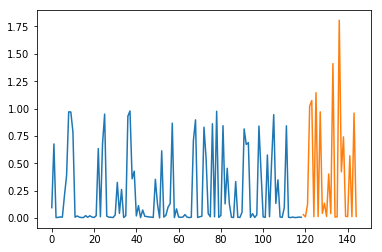


Reshaping Training Frames
X_train shape [(119, 1, 1415)] Type - <class 'numpy.ndarray'>
X_validate shape [(26, 1, 1415)] Type - <class 'numpy.ndarray'>
X_test shape [(26, 1, 1415)] Type - <class 'numpy.ndarray'>


In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
#
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))
#
# Plotting label over time for train, test
plt.plot(y_train)
plt.plot([None for i in y_train] + [x for x in y_validate + y_test])
plt.show()
#
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validate = X_validate.reshape((X_validate.shape[0], 1, X_validate.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))

### Designing the network

Building the LSTM Net

Train on 119 samples, validate on 26 samples
Epoch 1/100
 - 7s - loss: 0.7011 - val_loss: 1.2060
Epoch 2/100
 - 1s - loss: 0.9779 - val_loss: 0.4007
Epoch 3/100
 - 1s - loss: 0.4588 - val_loss: 0.5303
Epoch 4/100
 - 1s - loss: 0.4059 - val_loss: 0.2730
Epoch 5/100
 - 2s - loss: 0.2829 - val_loss: 0.3346
Epoch 6/100
 - 2s - loss: 0.3656 - val_loss: 0.3022
Epoch 7/100
 - 1s - loss: 0.3139 - val_loss: 0.2259
Epoch 8/100
 - 1s - loss: 0.2258 - val_loss: 0.2105
Epoch 9/100
 - 2s - loss: 0.2128 - val_loss: 0.2866
Epoch 10/100
 - 2s - loss: 0.2497 - val_loss: 0.2573
Epoch 11/100
 - 1s - loss: 0.2154 - val_loss: 0.1960
Epoch 12/100
 - 1s - loss: 0.1844 - val_loss: 0.1923
Epoch 13/100
 - 2s - loss: 0.1959 - val_loss: 0.2014
Epoch 14/100
 - 2s - loss: 0.2034 - val_loss: 0.1986
Epoch 15/100
 - 2s - loss: 0.1985 - val_loss: 0.1872
Epoch 16/100
 - 2s - loss: 0.1866 - val_loss: 0.1806
Epoch 17/100
 - 2s - loss: 0.1760 - val_loss: 0.1885
Epoch 18/100
 - 2s - loss: 0.1732 - val_loss: 0.1951
Epoch 19/1

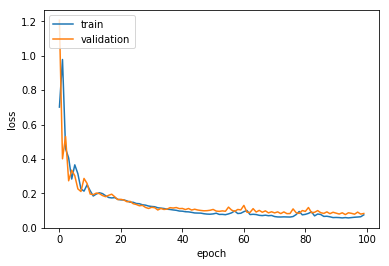

In [12]:
# Design network
model = ke.models.Sequential()
model.add(ke.layers.LSTM(X_train.shape[2], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(ke.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=100, 
                    batch_size=72, 
                    validation_data=(X_validate,y_validate), 
                    verbose=2, 
                    shuffle=False)
# plot history
#print(history.history.keys())
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluating the Model (Validation)

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [13]:
#
# Make copies of original validate data frames because these will be used further down for model refitting
xv = X_validate
yv = y_validate
#
# Make Prediction
yhat = model.predict(xv)
xv = xv.reshape((xv.shape[0], xv.shape[2]))
#
# Invert scaling
inv_yhat = np.concatenate((yhat, xv), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#
# invert scaling for actual
yv = yv.reshape((len(yv), 1))
inv_y = np.concatenate((yv, xv), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.587


### Evaluating the Model (Walk Forward Validation / Testing)

https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/

Train on 26 samples, validate on 26 samples
Epoch 1/1
 - 1s - loss: 0.0830 - val_loss: 0.0947


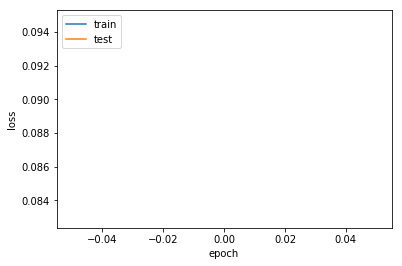

Test RMSE: 28.953


In [14]:
# fit network
history = model.fit(x=X_validate, 
                    y=y_validate, 
                    epochs=100, 
                    batch_size=72, 
                    validation_data=(X_test,y_test), 
                    verbose=2, 
                    shuffle=False)
# plot history
#print(history.history.keys())
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#
# Make copies of original validate data frames because these will be used further down for model refitting
xt = X_test
yt = y_test
#
# Make Prediction
yhat = model.predict(xt)
xt = xt.reshape((xt.shape[0], xt.shape[2]))
#
# Invert scaling
inv_yhat = np.concatenate((yhat, xt), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#
# invert scaling for actual
yt = yt.reshape((len(yt), 1))
inv_y = np.concatenate((yt, xt), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)